# Braitenberg Vehicle

This agent moves towards green and yellow goals and away from red goals and lava. It can only do that when it sees them in its current field of view. You could easily extend it to make more complex behavioural patterns, like going towards walls, too.

In [108]:
from animalai.envs.actions import AAIActions, AAIAction
# from animalai.envs.cameraparser import CameraParser
# from animalai.envs.cameraparser import CameraObjects
from animalai.envs.raycastparser import RayCastParser
from animalai.envs.raycastparser import RayCastObjects
from animalai.envs.environment import AnimalAIEnvironment
from gym_unity.envs import UnityToGymWrapper
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import deque

## Parameters

In [2]:
aai_seed = 128 # set the seed for the random number generator, and then vary this to make a population of agents

NUM_RAYS = 7 # number of rays to use in raycast, see here: https://github.com/Kinds-of-Intelligence-CFI/animal-ai/blob/main/docs/observations.md
STEP_LENGTH = 15 # how many steps to take before taking a random action, vary this to make a population of agents
NUM_EPISODES = 38 # add number of episodes for testing

agent_inference = True

agent_name = "cameraBraitenbergVehicle"

## Paths

In [3]:
configuration_file = r"/Users/nataszasiwinska/Documents/research_projects/animal-ai-main/configs/combined_short.yml"
env_path = r"/Users/nataszasiwinska/Documents/animal-ai/env/AAI3Mac.app"
log_folder_path = r"/Users/nataszasiwinska/Documents/research_projects/results"

In [181]:
class advancedBraitenberg():
    """Implements a simple Braitenberg vehicle agent that heads towards food
    Can change the number of rays but only responds to GOODGOALs, GOODGOALMULTI and BADGOAL"""
    def __init__(self, no_rays, max_degrees, step_length):
        self.actions = AAIActions()
        self.prev_action = self.actions.NOOP
        self.prev_prev_action = self.actions.NOOP
        self.GOODGOALCAMERA = np.array([0.7411765, 0.8784314, 0.5411765], dtype=np.float32)
        self.GOODGOALMULTICAMERA = np.array([0.9607843,  0.8666667,  0.40784314], dtype=np.float32)
        self.IMMOVABLECAMERA = np.array([0.7411765, 0.8784314, 0.5411765], dtype=np.float32) 
        self.forwards_counter = 0
        self.forwards_active = False
        self.last_saw_goal_left = False
        self.last_saw_goal_right = False
        self.last_saw_goal_ahead = False
        self.consecutive_steps_in_same_direction = 0
        self.listOfObjects = [RayCastObjects.GOODGOAL, RayCastObjects.GOODGOALMULTI, RayCastObjects.BADGOAL, RayCastObjects.IMMOVABLE, RayCastObjects.MOVABLE, RayCastObjects.ARENA]
        self.initialposition = None
        self.currentposition = None
        self.currentactionsequence = "Initial"
        self.currentstate = None

        self.no_rays = no_rays
        assert self.no_rays % 2 == 1

        self.step_length = step_length
        assert self.step_length >= 2

        self.max_degrees = max_degrees

        self.raycast_parser = RayCastParser(self.listOfObjects, self.no_rays)

    def prettyPrint(self, obs) -> str:
        """Prints the parsed observation"""
        return self.raycast_parser.prettyPrint(obs)
    
    def checkStationarity(self, vel_observations, threshold = 0.1):
        bool_array = (vel_observations <= np.array([threshold,threshold,threshold]))
        if sum(bool_array) == 3:
            return True
        else:
            return False
    
    def cameraObjectDetected(self, camobs, camobject) -> bool:
        if self.camera_ahead(camobs, camobject) or self.camera_left(camobs, camobject) or self.camera_right(camobs, camobject):
            return True
        else:
            return False
        
    def rayObjectDetected(self, rayobs, rayobject) -> bool:
        if self.ray_ahead(rayobs, rayobject) or self.ray_left(rayobs, rayobject) or self.ray_right(rayobs, rayobject):
            return True
        else:
            return False
        

    def get_action_sequence(self, observations) -> list:
        act_sequence = []

        rays = observations["rays"]

        rays = self.raycast_parser.parse(rays)

        velocities = observations["velocity"]

        camera_obs = observations["camera"]


        if self.rayObjectDetected(rays, RayCastObjects.GOODGOAL) or self.rayObjectDetected(rays, RayCastObjects.GOODGOALMULTI) or self.rayObjectDetected(rays, RayCastObjects.BADGOAL):
            self.current_state = "RaycastMode"
        elif not self.rayObjectDetected(rays, RayCastObjects.GOODGOAL) and not self.rayObjectDetected(rays, RayCastObjects.GOODGOALMULTI) and not self.rayObjectDetected(rays, RayCastObjects.BADGOAL) and (self.cameraObjectDetected(camera_obs, self.GOODGOALCAMERA) or self.cameraObjectDetected(camera_obs, self.GOODGOALMULTICAMERA)):
            self.current_state = "CameraMode"
        elif velocities[1] > 0.2:
            self.current_state = "RampClimbing"
        else:
            self.current_state = "ExplorationMode"


        if self.current_state == "RaycastMode":
            if not self.checkStationarity(velocities, threshold = 0.1):
                if self.ray_ahead(rays, RayCastObjects.GOODGOALMULTI) or self.ray_ahead(rays, RayCastObjects.GOODGOAL):
                    act_sequence.append(self.actions.FORWARDS)
                elif self.ray_left(rays, RayCastObjects.GOODGOALMULTI) or self.ray_left(rays, RayCastObjects.GOODGOAL):
                    act_sequence.append(self.actions.LEFT)
                elif self.ray_right(rays, RayCastObjects.GOODGOALMULTI) or self.ray_right(rays, RayCastObjects.GOODGOALMULTI):
                    act_sequence.append(self.actions.RIGHT)
            else:
                if self.ray_ahead(rays, RayCastObjects.GOODGOALMULTI) or self.ray_ahead(rays, RayCastObjects.GOODGOAL):
                    for i in range(self.step_length//2):
                        act_sequence.append(self.actions.BACKWARDS)
                    select_LR = random.randint(0,1)
                    if select_LR == 0:
                        action = self.actions.LEFT
                        opposite_action = self.actions.FORWARDSRIGHT
                    else:
                        action = self.actions.RIGHT
                        opposite_action = self.actions.FORWARDSLEFT
                    for i in range(8):
                        act_sequence.append(action)
                    for i in range(self.step_length//2):
                        act_sequence.append(opposite_action)
                elif self.ray_left(rays, RayCastObjects.GOODGOALMULTI) or self.ray_left(rays, RayCastObjects.GOODGOAL):
                    act_sequence.append(self.actions.LEFT)
                elif self.ray_right(rays, RayCastObjects.GOODGOALMULTI) or self.ray_right(rays, RayCastObjects.GOODGOALMULTI):
                    act_sequence.append(self.actions.RIGHT)
        elif self.current_state == "CameraMode":
            # if not self.checkStationarity(velocities, threshold = 0.1):
                if self.camera_ahead(camera_obs, self.GOODGOALCAMERA) or self.camera_ahead(camera_obs, self.GOODGOALMULTICAMERA):
                    for i in range(self.step_length):
                        act_sequence.append(self.actions.FORWARDS)
                        if (i%3 == 0):
                            act_sequence.append(self.actions.NOOP) 
                elif self.camera_left(camera_obs,self.GOODGOALCAMERA) or self.camera_left(camera_obs, self.GOODGOALMULTICAMERA):
                    for i in range(15): #to make full 90' turn
                        act_sequence.append(self.actions.LEFT)
                    for i in range(self.step_length):
                        act_sequence.append(self.actions.FORWARDS)
                    for i in range(15): #to make full 90' turn
                        act_sequence.append(self.actions.RIGHT)
                    for i in range(self.step_length):
                        act_sequence.append(self.actions.FORWARDS)
                        if (i%3 == 0):
                            act_sequence.append(self.actions.NOOP) 
                elif self.camera_right(camera_obs,self.GOODGOALCAMERA) or self.camera_right(camera_obs, self.GOODGOALMULTICAMERA):
                    for i in range(15): #to make full 90' turn
                        act_sequence.append(self.actions.RIGHT)
                    for i in range(self.step_length):
                        act_sequence.append(self.actions.FORWARDS)
                    for i in range(15): #to make full 90' turn
                        act_sequence.append(self.actions.LEFT)
                    for i in range(self.step_length):
                        act_sequence.append(self.actions.FORWARDS)
                        if (i%3 == 0):
                            act_sequence.append(self.actions.NOOP) 
            # else:
            #     if self.camera_ahead(camera_obs, self.GOODGOALCAMERA) or self.camera_ahead(camera_obs, self.GOODGOALMULTICAMERA):
            #         for i in range(self.step_length//2):
            #             act_sequence.append(self.actions.BACKWARDS)
            #         select_LR = random.randint(0,1)
            #         if select_LR == 0:
            #             action = self.actions.LEFT
            #             opposite_action = self.actions.FORWARDSRIGHT
            #         else:
            #             action = self.actions.RIGHT
            #             opposite_action = self.actions.FORWARDSLEFT
            #         for i in range(8):
            #             act_sequence.append(action)
            #         for i in range(self.step_length//2):
            #             act_sequence.append(opposite_action)
            #     elif self.camera_left(camera_obs,self.GOODGOALCAMERA) or self.camera_left(camera_obs, self.GOODGOALMULTICAMERA):
            #         act_sequence.append(self.actions.LEFT)
            #     elif self.camera_right(camera_obs,self.GOODGOALCAMERA) or self.camera_right(camera_obs, self.GOODGOALMULTICAMERA):
            #         act_sequence.append(self.actions.RIGHT)
        elif self.current_state == "RampClimbing":
            for i in range(self.step_length):
                act_sequence.append(self.actions.FORWARDS)
        elif self.current_state == "ExplorationMode":
            select_LR = random.randint(0,3)
            for i in range(15*select_LR):
                act_sequence.append(self.actions.LEFT)


            for i in range(self.step_length//2):
                act_sequence.append(self.actions.FORWARDS)
            for i in range(self.step_length):
                act_sequence.append(self.actions.BACKWARDS)
            for i in range(self.step_length//2):
                act_sequence.append(self.actions.FORWARDS)
            for i in range(15): #to make full 90' turn
                act_sequence.append(self.actions.RIGHT)
            for i in range(self.step_length//2):
                act_sequence.append(self.actions.BACKWARDS)
            for i in range(self.step_length):
                act_sequence.append(self.actions.FORWARDS)
                

            

        # if self.currentactionsequence == "Initial":

        #     if not self.rayObjectDetected(rays, RayCastObjects.GOODGOAL) and not self.rayObjectDetected(rays, RayCastObjects.GOODGOALMULTI) and not self.rayObjectDetected(rays, RayCastObjects.BADGOAL) and (self.cameraObjectDetected(camera_obs, self.GOODGOALCAMERA) or self.cameraObjectDetected(camera_obs, self.GOODGOALMULTICAMERA)):
        #         if self.camera_ahead(camera_obs, self.GOODGOALCAMERA) or self.camera_ahead(camera_obs, self.GOODGOALMULTICAMERA):
        #             for i in range(self.step_length):
        #                 act_sequence.append(self.actions.FORWARDS)
        #                 act_sequence.append(self.actions.NOOP) #incrementally slow down as gets closer
        #             self.currentactionsequence == "CameraGoalSeen"
        #         elif self.camera_left(camera_obs,self.GOODGOALCAMERA) or self.camera_left(camera_obs, self.GOODGOALMULTICAMERA):
        #             for i in range(15): #to make full 90' turn
        #                 act_sequence.append(self.actions.LEFT)
        #             for i in range(self.step_length):
        #                 act_sequence.append(self.actions.FORWARDS)
        #             for i in range(15): #to make full 90' turn
        #                 act_sequence.append(self.actions.RIGHT)
        #             for i in range(self.step_length):
        #                 act_sequence.append(self.actions.FORWARDS)
        #                 act_sequence.append(self.actions.NOOP) #incrementally slow down as gets closer
        #             self.currentactionsequence == "CameraGoalSeen"
        #         elif self.camera_right(camera_obs,self.GOODGOALCAMERA) or self.camera_right(camera_obs, self.GOODGOALMULTICAMERA):
        #             for i in range(15): #to make full 90' turn
        #                 act_sequence.append(self.actions.RIGHT)
        #             for i in range(self.step_length):
        #                 act_sequence.append(self.actions.FORWARDS)
        #             for i in range(15): #to make full 90' turn
        #                 act_sequence.append(self.actions.LEFT)
        #             for i in range(self.step_length):
        #                 act_sequence.append(self.actions.FORWARDS)
        #                 act_sequence.append(self.actions.NOOP) #incrementally slow down as gets closer
        #             self.currentactionsequence == "CameraGoalSeen"
        #         else:
        #             select_LR = random.randint(0,1)
        #             if select_LR == 0:
        #                 action = self.actions.FORWARDSLEFT
        #             else:
        #                 action = self.actions.FORWARDSRIGHT
        #             for i in range(self.step_length):
        #                 act_sequence.append(action)
        #             self.currentactionsequence = "NoGoalSeen"
        #     else:
        #         action = self.get_action_visible_object(rays)
        #         act_sequence.append(action)
        #         self.currentactionsequence = "RayGoalSeen"
        # elif self.currentactionsequence == "CameraGoalSeen":
        #     if not self.rayObjectDetected(rays, RayCastObjects.GOODGOAL) and not self.rayObjectDetected(rays, RayCastObjects.GOODGOALMULTI) and not self.rayObjectDetected(rays, RayCastObjects.BADGOAL) and not self.checkStationarity(velocities, threshold = 0.1):
        #         for i in range(self.step_length):
        #                 act_sequence.append(self.actions.FORWARDS)
        #                 act_sequence.append(self.actions.NOOP) #incrementally slow down as gets closer
        #         self.currentactionsequence == "CameraGoalSeen"
        #     elif not self.rayObjectDetected(rays, RayCastObjects.GOODGOAL) and not self.rayObjectDetected(rays, RayCastObjects.GOODGOALMULTI) and not self.rayObjectDetected(rays, RayCastObjects.BADGOAL) and self.checkStationarity(velocities, threshold = 0.1):
        #         select_LR = random.randint(0,1)
        #         if select_LR == 0:
        #             action = self.actions.LEFT
        #             opposite_action = self.actions.RIGHT
        #         else:
        #             action = self.actions.RIGHT
        #             opposite_action = self.actions.LEFT
                
        #         for i in range(15):
        #             act_sequence.append(action)
                
        #         for i in range(self.step_length):
        #             act_sequence.append(self.actions.FORWARDS)
        #             act_sequence.append(self.actions.NOOP) #incrementally slow down as gets closer
                
        #         for i in range(15):
        #             act_sequence.append(opposite_action)
                
        #         self.currentactionsequence == "CameraGoalSeen"
        #     else:
        #         action = self.get_action_visible_object(rays)
        #         act_sequence.append(action)
        #         self.currentactionsequence = "RayGoalSeen"
        # elif self.currentactionsequence == "RayGoalSeen":
        #     action = self.get_action_visible_object(rays)
        #     act_sequence.append(action)
        #     self.currentactionsequence = "RayGoalSeen"
        #     # elif self.cameraObjectDetected(camera_obs, self.GOODGOALCAMERA) or self.cameraObjectDetected(camera_obs, self.GOODGOALMULTICAMERA):
        #     #     action = self.get_action_visible_object(rays)
        #     #     act_sequence.append(action)
        #     #     self.currentactionsequence = "CameraGoalSeen"
        #     # else:
        #     #     select_LR = random.randint(0,1)
        #     #     if select_LR == 0:
        #     #         action = self.actions.FORWARDSLEFT
        #     #     else:
        #     #         action = self.actions.FORWARDSRIGHT
        #     #     for i in range(self.step_length):
        #     #         act_sequence.append(action)
        #     #     self.currentactionsequence == "NoGoalSeen"

        # elif self.currentactionsequence == "NoGoalSeen":
        #     select_LR = random.randint(0,1)
        #     if select_LR == 0:
        #         action = self.actions.FORWARDSLEFT
        #     else:
        #         action = self.actions.FORWARDSRIGHT
        #     for i in range(self.step_length):
        #         act_sequence.append(action)
        # else:
        #     pass

        return act_sequence
    
    def get_action_visible_object(self, raycasts) -> AAIAction:
        if (self.ray_ahead(raycasts, RayCastObjects.GOODGOAL) or (self.ray_ahead(raycasts,RayCastObjects.GOODGOALMULTI))):
            newAction = self.actions.FORWARDS
        elif (self.ray_left(raycasts, RayCastObjects.GOODGOAL) or (self.ray_left(raycasts,RayCastObjects.GOODGOALMULTI))):
            newAction = self.actions.LEFT
        elif (self.ray_right(raycasts, RayCastObjects.GOODGOAL) or (self.ray_right(raycasts, RayCastObjects.GOODGOALMULTI))):
            newAction = self.actions.RIGHT
        elif(self.ray_ahead(raycasts, RayCastObjects.BADGOAL)):
            select_LR = random.randint(0,1)
            if select_LR == 0:
                newAction = self.actions.BACKWARDSLEFT
            else:
                newAction = self.actions.BACKWARDSRIGHT
        elif(self.ray_left(raycasts, RayCastObjects.BADGOAL)):
            newAction = self.actions.BACKWARDSRIGHT
        elif(self.ray_right(raycasts, RayCastObjects.BADGOAL)):
            newAction = self.actions.BACKWARDSLEFT
        else:
            newAction = self.actions.NOOP
        
        return newAction



    
    def get_action(self, observations) -> AAIAction:
        """Returns the action to take given the current parsed raycast observation and other observations"""
        obs = observations["rays"]

        obs = self.raycast_parser.parse(obs)

        velocities = observations["velocity"]
        #print(velocities)
        position = observations["position"]

        if self.initialposition is None:
            self.initialposition = position

        self.currentposition = position

        camera_obs = observations["camera"]



        #newAction = self.actions.NOOP

        if self.camera_left(camera_obs, self.GOODGOALCAMERA) or self.camera_left(camera_obs, self.GOODGOALMULTICAMERA):
            self.last_saw_goal_left = True
            self.last_saw_goal_right = False

        if self.camera_ahead(camera_obs, self.GOODGOALCAMERA) or self.camera_ahead(camera_obs, self.GOODGOALMULTICAMERA):
            print("Goodgoal found ahead")
            self.last_saw_goal_ahead = True

        if self.camera_right(camera_obs, self.GOODGOALCAMERA) or self.camera_right(camera_obs, self.GOODGOALMULTICAMERA):
            print("Goodgoal found right")
            self.last_saw_goal_left = False
            self.last_saw_goal_right = True

        newAction = self.actions.NOOP #initialise the new action to be no action

        if (self.ray_ahead(obs, RayCastObjects.GOODGOAL) or self.ray_ahead(obs, RayCastObjects.GOODGOALMULTI)) and not self.checkStationarity(velocities):
            newAction = self.actions.FORWARDS
        elif self.ray_ahead(obs, RayCastObjects.BADGOAL) and self.prev_action != self.actions.LEFT and self.prev_action != self.actions.RIGHT:
            select_LR = random.randint(0,1)
            if select_LR == 0:
                newAction = self.actions.LEFT
            else:
                newAction = self.actions.RIGHT
        elif self.ray_ahead(obs, RayCastObjects.BADGOAL) and self.prev_action == self.actions.LEFT:
            newAction = self.actions.LEFT
        elif self.ray_ahead(obs, RayCastObjects.BADGOAL) and self.prev_action == self.actions.RIGHT:
            newAction = self.actions.RIGHT
        elif (self.ray_left(obs, RayCastObjects.GOODGOAL) or self.ray_left(obs, RayCastObjects.GOODGOALMULTI)) and not self.checkStationarity(velocities, threshold = 0.1):
            newAction = self.actions.LEFT
        elif (self.ray_right(obs, RayCastObjects.GOODGOAL) or self.ray_right(obs, RayCastObjects.GOODGOALMULTI)) and not self.checkStationarity(velocities, threshold = 0.1):
            newAction = self.actions.RIGHT
        elif self.checkStationarity(velocities, threshold = 0.1) and self.prev_action != self.actions.FORWARDSLEFT  and self.prev_action != self.actions.FORWARDSRIGHT:
            select_LR = random.randint(0,1)
            if select_LR == 0:
                newAction = self.actions.FORWARDSLEFT
            else:
                newAction = self.actions.FORWARDSRIGHT
        elif self.checkStationarity(velocities, threshold = 0.1) and self.prev_action == self.actions.FORWARDSLEFT:
            newAction = self.actions.FORWARDSLEFT
        elif self.checkStationarity(velocities, threshold = 0.1) and self.prev_action == self.actions.FORWARDSRIGHT:
            newAction = self.actions.FORWARDSRIGHT
        else:
            # if self.camera_ahead(camera_obs, self.GOODGOALCAMERA) and not self.camera_left(camera_obs, self.GOODGOALCAMERA) and not self.camera_right(camera_obs, self.GOODGOALCAMERA):
            #     newAction = self.actions.FORWARDS
            # elif self.camera_ahead(camera_obs, self.GOODGOALMULTICAMERA) and not self.camera_left(camera_obs, self.GOODGOALMULTICAMERA) and not self.camera_right(camera_obs, self.GOODGOALMULTICAMERA):
            #     newAction = self.actions.FORWARDS
            # elif self.camera_ahead(camera_obs, self.GOODGOALCAMERA) and self.camera_left(camera_obs, self.GOODGOALCAMERA) and not self.camera_right(camera_obs, self.GOODGOALCAMERA):
            #     newAction = self.actions.FORWARDSLEFT
            # elif self.camera_ahead(camera_obs, self.GOODGOALMULTICAMERA) and self.camera_left(camera_obs, self.GOODGOALMULTICAMERA) and not self.camera_right(camera_obs, self.GOODGOALMULTICAMERA):
            #     newAction = self.actions.FORWARDSLEFT
            # elif self.camera_ahead(camera_obs, self.GOODGOALCAMERA) and not self.camera_left(camera_obs, self.GOODGOALCAMERA) and self.camera_right(camera_obs, self.GOODGOALCAMERA):
            #     newAction = self.actions.FORWARDSRIGHT
            # elif self.camera_ahead(camera_obs, self.GOODGOALMULTICAMERA) and not self.camera_left(camera_obs, self.GOODGOALMULTICAMERA) and self.camera_right(camera_obs, self.GOODGOALMULTICAMERA):
            #     newAction = self.actions.FORWARDSRIGHT
            # elif not self.camera_ahead(camera_obs, self.GOODGOALCAMERA) and self.camera_left(camera_obs, self.GOODGOALCAMERA) and not self.camera_right(camera_obs, self.GOODGOALCAMERA):
            #     newAction = self.actions.LEFT
            # elif not self.camera_ahead(camera_obs, self.GOODGOALMULTICAMERA) and self.camera_left(camera_obs, self.GOODGOALMULTICAMERA) and not self.camera_right(camera_obs, self.GOODGOALMULTICAMERA):
            #     newAction = self.actions.LEFT
            # elif not self.camera_ahead(camera_obs, self.GOODGOALCAMERA) and not self.camera_left(camera_obs, self.GOODGOALCAMERA) and self.camera_right(camera_obs, self.GOODGOALCAMERA):
            #     newAction = self.actions.RIGHT
            # elif not self.camera_ahead(camera_obs, self.GOODGOALMULTICAMERA) and not self.camera_left(camera_obs, self.GOODGOALMULTICAMERA) and self.camera_right(camera_obs, self.GOODGOALMULTICAMERA):
            #     newAction = self.actions.RIGHT
            # else:
                if self.last_saw_goal_ahead and not self.last_saw_goal_left and not self.last_saw_goal_right:
                    if self.prev_action == self.actions.NOOP:
                        newAction = self.actions.FORWARDS
                    else:
                        newAction = self.actions.NOOP
                elif self.last_saw_goal_left and not self.last_saw_goal_right and not self.last_saw_goal_ahead:
                    #if np.any(np.all(middle == object, axis=-1))
                    newAction = self.actions.FORWARDSLEFT
                    self.last_saw_goal_ahead = True
                    self.last_saw_goal_left = False
                elif self.last_saw_goal_right and not self.last_saw_goal_left:
                    newAction = self.actions.RIGHT
                    self.last_saw_goal_ahead = True
                    self.last_saw_goal_right = False
                else:
                    newAction = self.prev_action
        
        # if self.checkStationarity(velocities) and self.prev_action != self.actions.FORWARDSLEFT and self.prev_action != self.actions.FORWARDSRIGHT:
        #     select_LR = random.randint(0,1)
        #     if select_LR == 0:
        #         newAction = self.actions.FORWARDSLEFT
        #     else:
        #         newAction = self.actions.FORWARDSRIGHT
        # elif self.checkStationarity(velocities) and self.prev_action == self.actions.FORWARDSLEFT:
        #     newAction = self.actions.FORWARDSLEFT
        # elif self.checkStationarity(velocities) and self.prev_action == self.actions.FORWARDSRIGHT:
        #     newAction = self.actions.FORWARDSRIGHT
        # elif self.ahead(obs, RayCastObjects.GOODGOALMULTI) and not self.checkStationarity(velocities):
        #     newAction = self.actions.FORWARDS
        # elif self.left(obs, RayCastObjects.GOODGOALMULTI) and not self.checkStationarity(velocities):
        #     newAction = self.actions.LEFT
        # elif self.right(obs, RayCastObjects.GOODGOALMULTI) and not self.checkStationarity(velocities):
        #     newAction = self.actions.RIGHT
        # elif self.ahead(obs, RayCastObjects.GOODGOAL) and not self.checkStationarity(velocities):
        #     newAction = self.actions.FORWARDS
        # elif self.left(obs, RayCastObjects.GOODGOAL) and not self.checkStationarity(velocities):
        #     newAction = self.actions.LEFT
        # elif self.right(obs, RayCastObjects.GOODGOAL) and not self.checkStationarity(velocities):
        #     newAction = self.actions.RIGHT
        # elif self.ahead(obs, RayCastObjects.BADGOAL) and not self.checkStationarity(velocities):
        #     newAction = self.actions.BACKWARDS
        # elif self.left(obs, RayCastObjects.BADGOAL) and not self.checkStationarity(velocities):
        #     newAction = self.actions.RIGHT
        # elif self.right(obs, RayCastObjects.BADGOAL) and not self.checkStationarity(velocities):
        #     newAction = self.actions.LEFT
        # elif self.ahead(obs, RayCastObjects.IMMOVABLE) and not self.checkStationarity(velocities):
        #     select_LR = random.randint(0,1)
        #     if select_LR == 0:
        #         newAction = self.actions.FORWARDSLEFT
        #     else:
        #         newAction = self.actions.FORWARDSRIGHT
        # elif ((self.ahead(obs, RayCastObjects.IMMOVABLE) and self.prev_action == self.actions.FORWARDSLEFT) or (self.left(obs, RayCastObjects.IMMOVABLE) and not self.ahead(obs, RayCastObjects.IMMOVABLE))) and not self.checkStationarity(velocities):
        #     newAction = self.actions.FORWARDSLEFT
        # elif ((self.ahead(obs, RayCastObjects.IMMOVABLE) and self.prev_action == self.actions.FORWARDSRIGHT) or (self.right(obs, RayCastObjects.IMMOVABLE) and not self.ahead(obs, RayCastObjects.IMMOVABLE))) and not self.checkStationarity(velocities):
        #     newAction = self.actions.FORWARDSRIGHT
        # else:
        #     newAction = self.prev_action        
        # self.prev_action = newAction
        
        return newAction
    
    def camera_ahead(self, obs, object):
        """Returns true if the input object is ahead of the agent"""
        middle = obs[:, obs.shape[1]//3:(obs.shape[1]//3)*2, :]
        if np.any(np.all(middle == object, axis=-1)):
            print("found good goal middle!")
            return True
        else:
            return False

    def camera_left(self, obs, object):
        """Returns true if the input object is left of the agent"""
        left_half = obs[:, :(obs.shape[1]//3)-1, :]
        if np.any(np.all(left_half == object, axis=-1)):
            print("found goal left!")
            return True
        else:
            return False


    def camera_right(self, obs, object):
        """Returns true if the input object is right of the agent"""
        right_half = obs[:, ((obs.shape[1]//3)*2)+1:, :]
        if np.any(np.all(right_half == object, axis=-1)):
            print("found goal right!")
            return True
        else:
            return False

    def ray_ahead(self, obs, object):
        """Returns true if the input object is ahead of the agent"""
        if(obs[self.listOfObjects.index(object)][int((self.no_rays-1)/2)] > 0):
            #print("found " + str(object) + " ahead")
            return True
        return False

    def ray_left(self, obs, object):
        """Returns true if the input object is left of the agent"""
        for i in range(int((self.no_rays-1)/2)):
            if(obs[self.listOfObjects.index(object)][i] > 0):
                #print("found " + str(object) + " left")
                return True
        return False

    def ray_right(self, obs, object):
        """Returns true if the input object is right of the agent"""
        for i in range(int((self.no_rays-1)/2)):
            if(obs[self.listOfObjects.index(object)][i+int((self.no_rays-1)/2) + 1] > 0):
                #print("found " + str(object) + " right")
                return True
        return False

In [183]:
def watch_vanilla_braitenberg_agent_single_config(configuration_file: str, agent: advancedBraitenberg):
    
    port = 4000 + random.randint(
        0, 1000
        )  # use a random port to avoid problems if a previous version exits slowly
    
    aai_env = AnimalAIEnvironment( 
    inference=True, #Set true when watching the agent
    seed = 123,
    worker_id=random.randint(0, 65500),
    file_name="../../env/AnimalAI",
    arenas_configurations=configuration_file,
    base_port=port,
    useCamera=True,
    useRayCasts=True,
    raysPerSide = int((agent.no_rays)/2),
    rayMaxDegrees = agent.max_degrees
    )

    behavior = list(aai_env.behavior_specs.keys())[0] # by default should be AnimalAI?team=0

    done = False
    episodeReward = 0

    aai_env.step() # take first step to get an observation

    dec, term = aai_env.get_steps(behavior)
 
    while not done:

        observations = aai_env.get_obs_dict(dec.obs)


        #raycasts = observations["rays"] # Get the raycast data

        action_sequence = agent.get_action_sequence(observations)
        print(action_sequence)
        for act in range(len(action_sequence)):
            action = action_sequence[act]

            print(action)

            aai_env.set_actions(behavior, action.action_tuple)

            aai_env.step()

            dec, term = aai_env.get_steps(behavior)

            observations = aai_env.get_obs_dict(dec.obs)

        
            if len(dec.reward) > 0 and len(term) <= 0:
                episodeReward += dec.reward

            elif len(term) > 0: #Episode is over
                episodeReward += term.reward
                print(f"Episode Reward: {episodeReward}")
                done = True
                break
        
            else:
                pass

            observations = aai_env.get_obs_dict(dec.obs)
            rays = agent.raycast_parser.parse(observations['rays'])
            if (agent.rayObjectDetected(rays, RayCastObjects.GOODGOAL) or agent.rayObjectDetected(rays, RayCastObjects.GOODGOALMULTI)) and agent.current_state != "RaycastMode":
                break

    aai_env.close()

In [184]:
configuration_file = r"C:\Users\kv301\Documents\comparative-object-permanence\configs\tests_agents\basic_controls\OP-Controls-Basic15LO-MovingGreen-RightMedium-4-NA-0-NA.yml"

singleEpisodeBraitenberg = advancedBraitenberg(no_rays=11,
                                             max_degrees=30,
                                             step_length=15)
    
watch_vanilla_braitenberg_agent_single_config(configuration_file=configuration_file, agent = singleEpisodeBraitenberg)

[INFO] Connected to Unity environment with package version 2.1.0-exp.1 and communication version 1.5.0
[INFO] Connected new brain: AnimalAI?team=0
found goal right!
found goal right!
[right, right, right, right, right, right, right, right, right, right, right, right, right, right, right, forwards, forwards, forwards, forwards, forwards, forwards, forwards, forwards, forwards, forwards, forwards, forwards, forwards, forwards, forwards, left, left, left, left, left, left, left, left, left, left, left, left, left, left, left, forwards, noop, forwards, forwards, forwards, noop, forwards, forwards, forwards, noop, forwards, forwards, forwards, noop, forwards, forwards, forwards, noop, forwards, forwards]
right
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


KeyboardInterrupt: 

In [5]:
random.seed(aai_seed) #set seed for random action selection

port = 5005 + random.randint(
    0, 1000
)  # use a random port to avoid problems if a previous version exits slowly

aai_env = AnimalAIEnvironment( 
    inference=agent_inference,
    seed = aai_seed,
    log_folder = log_folder_path,
    worker_id=aai_seed,
    file_name=env_path,
    arenas_configurations=configuration_file,
    base_port=port,
    useCamera=True,
    resolution=1080,
    useRayCasts=True,
    raysPerSide=int((NUM_RAYS-1)/2),
    #raysMaxDegrees=30
)
env = UnityToGymWrapper(aai_env, uint8_visual=True, allow_multiple_obs=True, flatten_branched=True)

obs = aai_env.reset()


braitenbergAgent = Braitenberg(NUM_RAYS, STEP_LENGTH)
behavior = list(aai_env.behavior_specs.keys())[0] # by default should be AnimalAI?team=0



reward_list = []

firststep = True
for _episode in range(NUM_EPISODES): #Run episodes with the Braitenberg-style agent
    if firststep:
        aai_env.step() # Need to make a first step in order to get an observation.
        firststep = False

    dec, term = aai_env.get_steps(behavior)
    done = False
    episodeReward = 0

    while not done:
        camera = aai_env.get_obs_dict(behavior)["rays"]
        #camera = aai_env.get_obs_dict(dec.obs)["camera"] # Get the camera data
        velocity = aai_env.get_obs_dict(dec.obs)["velocity"]
        #NUM_RAYS = len(aai_env.get_obs_dict(dec.obs)["rays"])
        raycasts = aai_env.get_obs_dict(dec.obs)["rays"] # Get the raycast data
        # print(braitenbergAgent.prettyPrint(raycasts)) #print raycasts in more readable format
        movement = aai_env.get_obs_dict(dec.obs)["position"]
        # print(movement)
        action = braitenbergAgent.get_action_camera(raycasts, STEP_LENGTH)
        # print(action)
        aai_env.set_actions(behavior, action.action_tuple)
        aai_env.step()
        #print(velocity) 
        #print(f"Raycast length: {len(raycast_obs)}")
        #print(f"Raycast data: {raycast_obs}")
        #print(f"self.numberOfRays: {NUM_RAYS}")
        #print(f"self.numberDetectableObjects: {braitenbergAgent.raycast_parser.numberDetectableObjects}")
        #braitenbergAgent.interact_with_immovable(raycast_obs, velocity)
        observations = aai_env.get_obs_dict(dec.obs)
        #action = agent.get_actions(observations)
        #action = braitenbergAgent.get_action_camera(camera, STEP_LENGTH, velocity, raycast_obs)
        #aai_env.set_actions(behavior, action.action_tuple)
        #aai_env.step()
        dec, term = aai_env.get_steps(behavior)
        if len(dec.reward) > 0:
            episodeReward += dec.reward
        if len(term) > 0: #Episode is over
            episodeReward += term.reward
            print(F"Episode Reward: {episodeReward}")
            reward_list.append(episodeReward)
            done = True
            firststep = True 
aai_env.close()

reward_df = pd.DataFrame(reward_list, columns = ['finalRewards'])

csv_path = log_folder_path + "/" + agent_name + "_Seed_" + str(aai_seed) + "_StepLength_" + str(STEP_LENGTH) + ".csv"
reward_df.to_csv(csv_path, index = False)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
print(f"Raycast length: {len(raycast)}")

NameError: name 'raycast' is not defined

In [ ]:
class RayCastParser():
    def parse(self, raycast) -> np.ndarray:
        print(f"Raycast length: {len(raycast)}")
        print(f"self.numberOfRays: {self.numberOfRays}")
        print(f"self.numberDetectableObjects: {self.numberDetectableObjects}")
        
        assert (len(raycast) == self.numberOfRays *
                (self.numberDetectableObjects+2))

In [ ]:
aai_env.close()


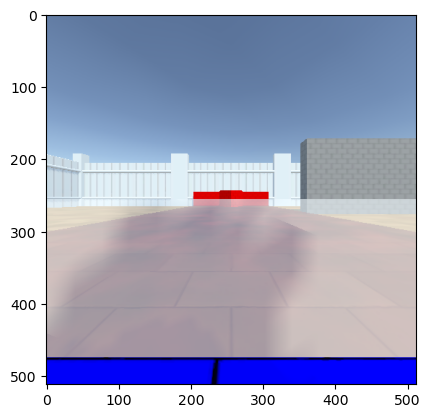

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(camera[:,:,:])

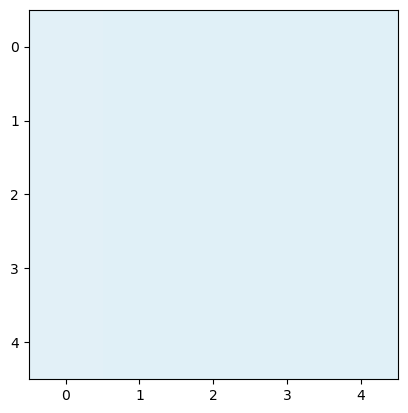

In [ ]:
plt.imshow(camera[210:215,105:110,:])

In [ ]:
print(camera[260:262,230:232,:])

[[[0.7411765 0.8784314 0.5411765]
  [0.7411765 0.8784314 0.5411765]]

 [[0.7411765 0.8784314 0.5411765]
  [0.7411765 0.8784314 0.5411765]]]
